# Kaggle, Tabular Playground Series - Aug 2022, done by Zhuk Dmytro

This data represents the results of a large product testing study. For each product_code you are given 
a number of product attributes (fixed for the code) as well as a number of measurement values for each 
individual product, representing various lab testing methods. Each product is used in a simulated real-world 
environment experiment, and and absorbs a certain amount of fluid (loading) to see whether or not it fails.

Your task is to use the data to predict individual product failures of new codes with their individual lab test results.

Files
train.csv - the training data, which includes the target failure
test.csv - the test set; your task is to predict the likelihood each id will experience a failure
sample_submission.csv - a sample submission file in the correct format

Submission File
For each id in the test set, you must predict a probability a failure. 
The file should contain a header and have the following format:

id,failure
26570,0.2
26571,0.1
26572,0.9
etc.

# EDA

In [43]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# See first 5 instances
df = pd.read_csv("train.csv")
df.head(5)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [45]:
# Show all columns
df.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

In [46]:
# Shape of the data
df.shape

(26570, 26)

In [47]:
# Describe all dataset in general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

In [48]:
# Show all variables with NaN values count  
df.isnull().sum()

id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [49]:
# Convert categorical variables (product_code, attribute_0, attribute_1) into indicator variables 
df = df.drop(["product_code"], axis = 1)
df = pd.get_dummies(df)
df

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,measurement_14,measurement_15,measurement_16,measurement_17,failure,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_8
0,0,80.10,9,5,7,8,4,18.040,12.518,15.748,...,NaN,13.034,14.684,764.100,0,0,1,0,0,1
1,1,84.89,9,5,14,3,3,18.213,11.540,17.717,...,15.425,14.395,15.631,682.057,0,0,1,0,0,1
2,2,82.43,9,5,12,1,5,18.057,11.652,16.738,...,18.631,14.094,17.946,663.376,0,0,1,0,0,1
3,3,101.07,9,5,13,2,6,17.295,11.188,18.576,...,15.562,16.154,17.172,826.282,0,0,1,0,0,1
4,4,188.06,9,5,9,2,8,19.346,12.950,16.990,...,12.760,13.153,16.412,579.885,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,26565,158.95,6,9,6,16,4,16.301,13.259,18.068,...,18.572,16.144,NaN,729.131,0,0,1,0,1,0
26566,26566,146.02,6,9,10,12,8,17.543,NaN,17.984,...,14.322,13.146,16.471,853.924,0,0,1,0,1,0
26567,26567,115.62,6,9,1,10,1,15.670,11.535,16.778,...,16.599,15.590,14.065,750.364,0,0,1,0,1,0
26568,26568,106.38,6,9,2,9,4,18.059,NaN,16.918,...,15.485,13.624,12.865,730.156,0,0,1,0,1,0


In [50]:
# Use KNN-imputation to fill missing NaN values
from sklearn.impute import KNNImputer
knn_imp = KNNImputer(n_neighbors=3)
df.loc[:, :] = knn_imp.fit_transform(df)
df.isnull().sum()

id                        0
loading                   0
attribute_2               0
attribute_3               0
measurement_0             0
measurement_1             0
measurement_2             0
measurement_3             0
measurement_4             0
measurement_5             0
measurement_6             0
measurement_7             0
measurement_8             0
measurement_9             0
measurement_10            0
measurement_11            0
measurement_12            0
measurement_13            0
measurement_14            0
measurement_15            0
measurement_16            0
measurement_17            0
failure                   0
attribute_0_material_5    0
attribute_0_material_7    0
attribute_1_material_5    0
attribute_1_material_6    0
attribute_1_material_8    0
dtype: int64

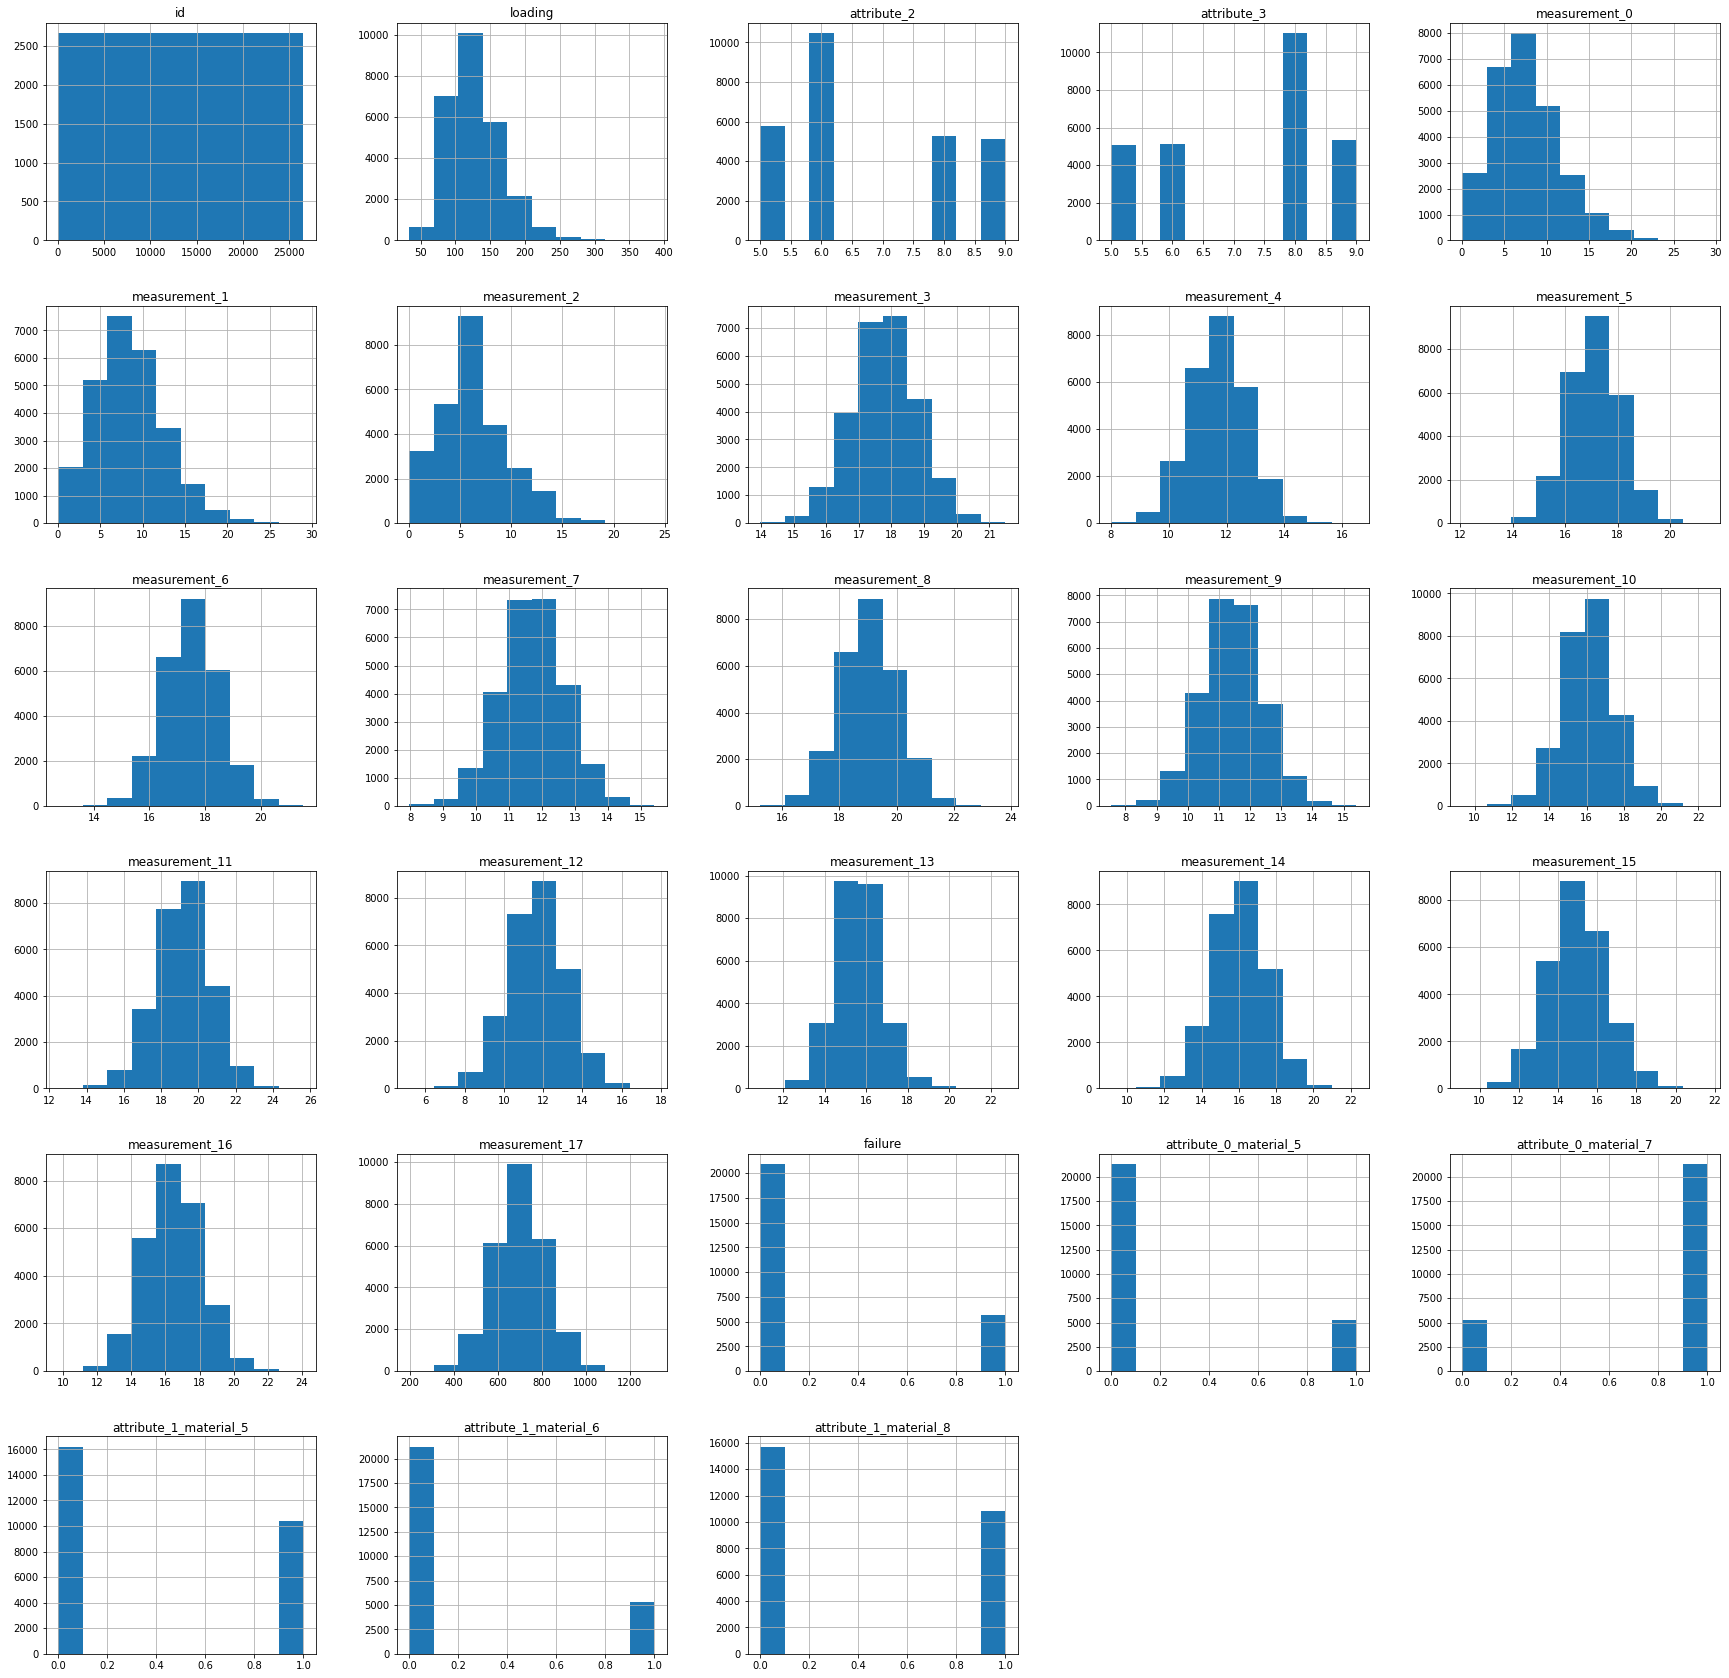

In [51]:
# Show all distibutions of numerical variables
df.hist(figsize = (30,30))
plt.show()

In [52]:
# Let's review the target variable
df["failure"].value_counts()

0.0    20921
1.0     5649
Name: failure, dtype: int64

The target variable is imbalanced - there are lots of failures, failure is more common than success, though accuracy may be not that accurate metric to measure performance of the model. 

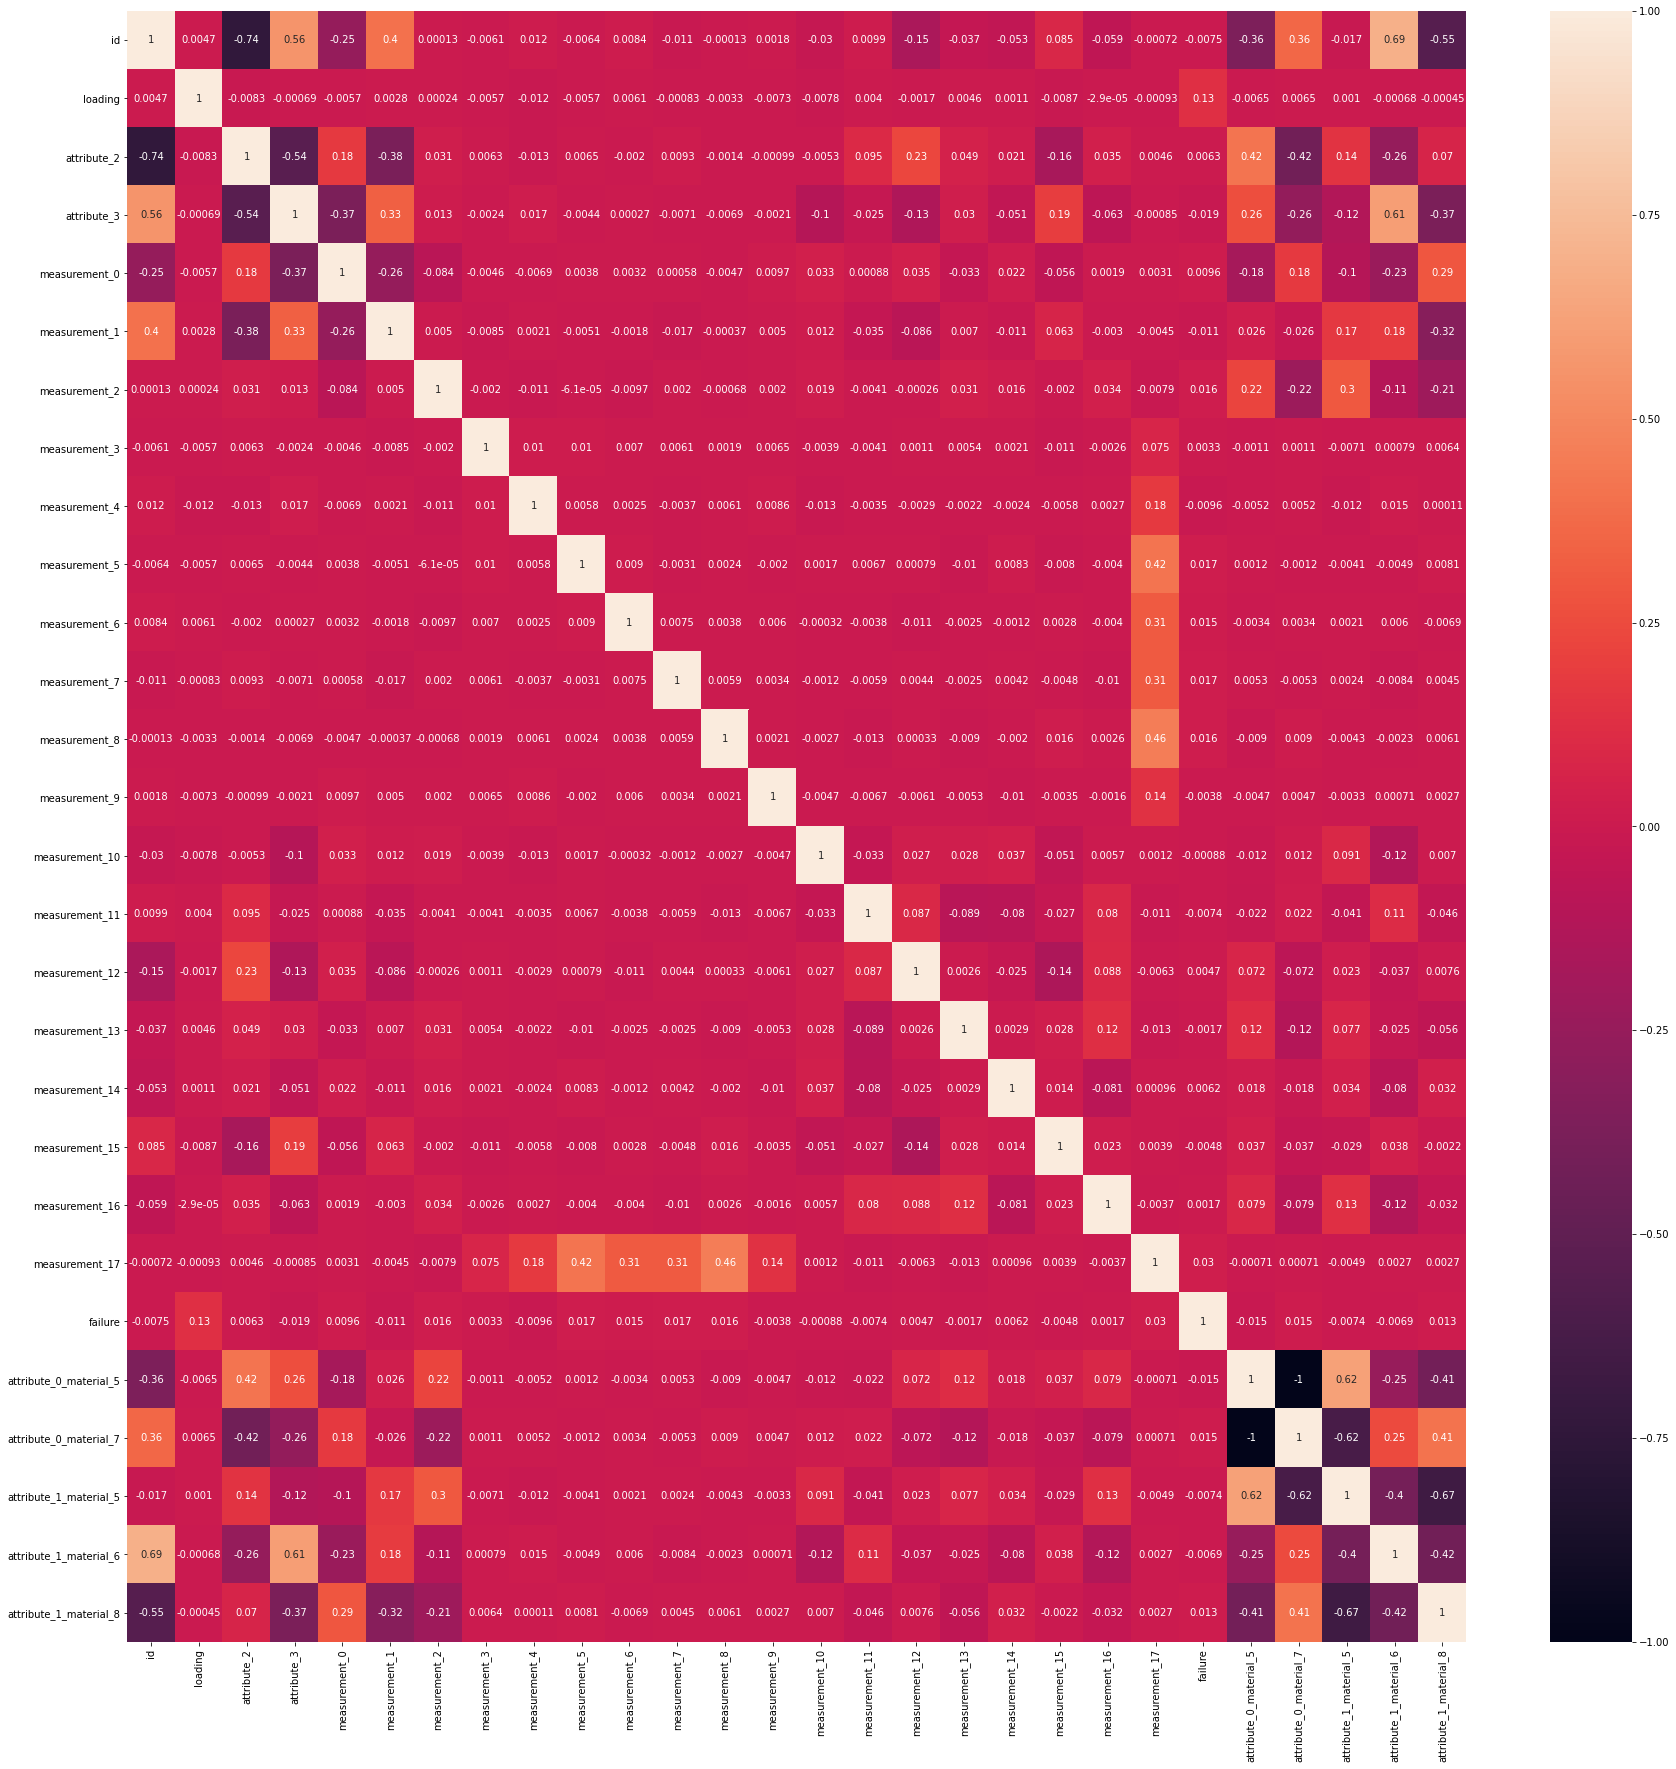

In [53]:
# Correlation heatmap 
plt.figure(figsize = (30,30))
sns.heatmap(df.corr(), annot = True)
plt.show()

# Machine Learning model 

In [54]:
# Assign X and y
y = df["failure"]
X = df.drop(["failure", "id"], axis = 1)

In [55]:
X.head(5)

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_8
0,80.10,9.0,5.0,7.0,8.0,4.0,18.040,12.518,15.748,19.292,...,15.029,14.909333,13.034,14.684,764.100,0.0,1.0,0.0,0.0,1.0
1,84.89,9.0,5.0,14.0,3.0,3.0,18.213,11.540,17.717,17.893,...,14.732,15.425000,14.395,15.631,682.057,0.0,1.0,0.0,0.0,1.0
2,82.43,9.0,5.0,12.0,1.0,5.0,18.057,11.652,16.738,18.240,...,16.711,18.631000,14.094,17.946,663.376,0.0,1.0,0.0,0.0,1.0
3,101.07,9.0,5.0,13.0,2.0,6.0,17.295,11.188,18.576,18.339,...,15.250,15.562000,16.154,17.172,826.282,0.0,1.0,0.0,0.0,1.0
4,188.06,9.0,5.0,9.0,2.0,8.0,19.346,12.950,16.990,15.746,...,16.182,12.760000,13.153,16.412,579.885,0.0,1.0,0.0,0.0,1.0


In [56]:
# Import all necessary libraries for machine learning tasks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from scipy.stats import uniform

In [57]:
# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [58]:
# Normalize features
stand = StandardScaler()
X_stand = stand.fit_transform(X_train)
X_train.columns

Index(['loading', 'attribute_2', 'attribute_3', 'measurement_0',
       'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4',
       'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8',
       'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12',
       'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16',
       'measurement_17', 'attribute_0_material_5', 'attribute_0_material_7',
       'attribute_1_material_5', 'attribute_1_material_6',
       'attribute_1_material_8'],
      dtype='object')

In [59]:
# Find the best parameters for the models, print RandomizedSearch CV results, add the best model to the list
a = list()
def RandomSearchCV(model, params):
    rand = RandomizedSearchCV(model, params, cv = 3, scoring = "roc_auc")
    rand.fit(X_stand, y_train)
    a.append(rand.best_estimator_)
    return rand.cv_results_ 

In [60]:
RandomSearchCV(LogisticRegression(), {"C": uniform(loc = 0, scale = 10), "solver": ["saga"], "penalty": ["elasticnet", "l1", "l2"]})

{'mean_fit_time': array([0.07329535, 0.09477814, 0.11978563, 0.0624946 , 0.09428708,
        0.11716731, 0.07397429, 0.11833882, 0.07771341, 0.07808439]),
 'std_fit_time': array([1.03323380e-02, 8.31115046e-04, 2.65285852e-02, 1.25893639e-05,
        1.16320391e-02, 2.30025839e-02, 7.04636101e-03, 3.66326919e-02,
        8.52287490e-03, 3.09652615e-05]),
 'mean_score_time': array([0.00520738, 0.        , 0.        , 0.00519784, 0.00098872,
        0.00694609, 0.00684786, 0.        , 0.00098681, 0.        ]),
 'std_score_time': array([0.00736435, 0.        , 0.        , 0.00735086, 0.00139826,
        0.00782321, 0.00621734, 0.        , 0.00139557, 0.        ]),
 'param_C': masked_array(data=[5.93941053436306, 0.3333950317225354,
                    4.287118415938249, 6.111334740019664,
                    0.5182606904586851, 3.5348362604514936,
                    3.8636070110410827, 4.497330592515985,
                    7.408781001125229, 5.379985956034433],
              mask=[False

In [61]:
RandomSearchCV(DecisionTreeClassifier(), {"max_depth": [i for i in range(1,11)], "max_leaf_nodes": [i for i in range(2,11)]})

{'mean_fit_time': array([0.05047353, 0.07153869, 0.06017176, 0.06748573, 0.03989259,
        0.07612952, 0.06881324, 0.04358379, 0.06216709, 0.06582363]),
 'std_fit_time': array([8.76836074e-03, 8.06949676e-03, 1.24377281e-03, 4.09872698e-03,
        2.97360213e-07, 8.31809210e-03, 3.28911053e-03, 4.44087456e-04,
        4.70415116e-04, 2.15346845e-03]),
 'mean_score_time': array([0.        , 0.00198547, 0.0023276 , 0.00299263, 0.0026602 ,
        0.00299191, 0.00333722, 0.00328183, 0.00232752, 0.00265996]),
 'std_score_time': array([0.00000000e+00, 1.40398902e-03, 4.70077860e-04, 1.94667955e-07,
        4.70134086e-04, 1.16800773e-06, 4.87667174e-04, 5.08461406e-04,
        4.70134086e-04, 4.70134046e-04]),
 'param_max_leaf_nodes': masked_array(data=[3, 6, 4, 7, 7, 7, 5, 10, 5, 6],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[7, 5

In [62]:
RandomSearchCV(KNeighborsClassifier(), {"n_neighbors": [i for i in range(1,11)]})

{'mean_fit_time': array([0.00230273, 0.00167044, 0.006205  , 0.00100684, 0.00200208,
        0.00300026, 0.00332419, 0.00334215, 0.00299215, 0.00266957]),
 'std_fit_time': array([1.67997489e-03, 1.24618163e-03, 6.77053391e-03, 1.42388913e-03,
        1.41569659e-03, 1.18075382e-05, 1.24345421e-03, 4.72396077e-04,
        1.94667955e-07, 4.77088902e-04]),
 'mean_score_time': array([2.30500746, 2.33891328, 2.34072709, 2.79901155, 2.83368429,
        3.20272024, 3.05550599, 2.77388565, 2.75596197, 2.81113879]),
 'std_score_time': array([0.10210553, 0.02397725, 0.0200475 , 0.08949824, 0.02827926,
        0.15285027, 0.34377681, 0.04611063, 0.03710578, 0.03243603]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 

In [63]:
RandomSearchCV(RandomForestClassifier(), {"n_estimators": [i for i in range(1,11)], "max_features": uniform(loc = 0, scale = 1)})

{'mean_fit_time': array([0.04157654, 0.62199569, 0.30585774, 0.5861121 , 0.45211132,
        0.53890173, 0.17386738, 0.94090947, 1.06315295, 0.01495965]),
 'std_fit_time': array([0.00309124, 0.02236003, 0.0099096 , 0.01468209, 0.00206318,
        0.0150703 , 0.00554337, 0.03132287, 0.03786466, 0.00081439]),
 'mean_score_time': array([0.00596229, 0.01229604, 0.00996423, 0.01196734, 0.00698201,
        0.00730618, 0.0036575 , 0.01217135, 0.01295431, 0.00365726]),
 'std_score_time': array([1.27731454e-05, 4.62884798e-04, 1.34869915e-05, 1.63258223e-06,
        1.12391596e-07, 4.75799000e-04, 4.70134046e-04, 2.45193137e-03,
        1.34649635e-05, 4.70134046e-04]),
 'param_max_features': masked_array(data=[0.07482544466865437, 0.3472510291005524,
                    0.26462135876688386, 0.3561184254387316,
                    0.5646012763557281, 0.6615644204553416,
                    0.7890803854012132, 0.6745085830404751,
                    0.5862096392419615, 0.003420027818038407],
   

In [64]:
RandomSearchCV(GradientBoostingClassifier(), {"n_estimators": [i for i in range(1,11)], "learning_rate": [0, 1]})

{'mean_fit_time': array([0.39545019, 0.00520833, 0.00520754, 0.00199588, 0.00236901,
        0.11255725, 0.18499668, 0.00300399, 0.0029695 , 0.00332483]),
 'std_fit_time': array([1.13291610e-02, 7.36569564e-03, 7.36457172e-03, 1.41160736e-03,
        9.04182259e-04, 4.48976352e-03, 1.03501818e-02, 1.33348733e-05,
        7.87565342e-04, 4.69965550e-04]),
 'mean_score_time': array([0.00619451, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00296942, 0.        , 0.        , 0.        ]),
 'std_score_time': array([6.75549759e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.38349108e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 'param_n_estimators': masked_array(data=[7, 6, 3, 10, 8, 2, 3, 5, 1, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[1,

In [65]:
a # Print models with the best parameters (according to the RandomSearchCV)

[LogisticRegression(C=0.3333950317225354, penalty='l1', solver='saga'),
 DecisionTreeClassifier(max_depth=7, max_leaf_nodes=7),
 KNeighborsClassifier(n_neighbors=10),
 RandomForestClassifier(max_features=0.3561184254387316, n_estimators=8),
 GradientBoostingClassifier(learning_rate=1, n_estimators=2)]

LogisticRegression(C=0.3333950317225354, penalty='l1', solver='saga') 0.5738044886644231


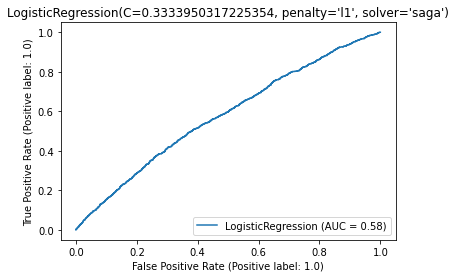

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=7) 0.5504174177485615


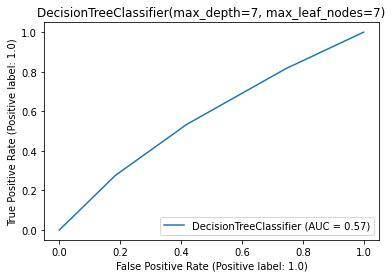

KNeighborsClassifier(n_neighbors=10) 0.5301215364157981


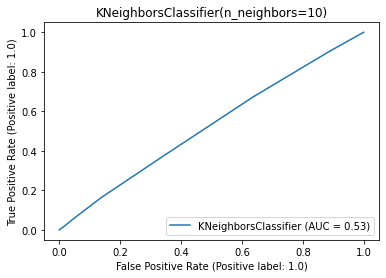

RandomForestClassifier(max_features=0.3561184254387316, n_estimators=8) 0.5042912063493753


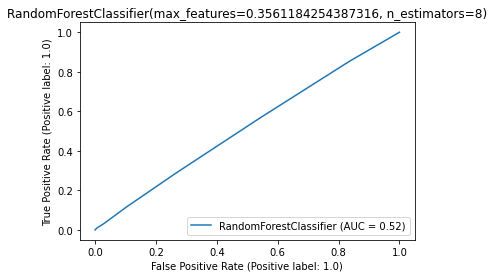

GradientBoostingClassifier(learning_rate=1, n_estimators=2) 0.5448630189645478


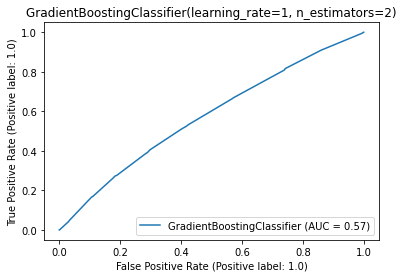

In [82]:
# Print roc_auc metric for performance measuring, choose the best model 
for i in a:
    i.fit(X_stand, y_train)
    print(str(i) + " " + str(np.mean(cross_val_score(i, stand.transform(X_test), y_test, cv = 10, scoring = "roc_auc"))))
    
    RocCurveDisplay.from_estimator(i, stand.transform(X_test), y_test)
    plt.title(i)
    plt.show()

In [83]:
# Train the best model (LogisticRegression)
model = a[0]
model.fit(X_stand, y_train)

LogisticRegression(C=0.3333950317225354, penalty='l1', solver='saga')

In [84]:
# Prepare test dataframe for predicting probability
df1 = pd.read_csv("test.csv")
id_pred = df1["id"]
df1 = df1.drop(["id", "product_code"], axis = 1)
df1 = pd.get_dummies(df1)
from sklearn.impute import KNNImputer
knn_imp = KNNImputer(n_neighbors=3)
df1.loc[:, :] = knn_imp.fit_transform(df1)
df1.head(5)

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7
0,119.57,6.0,4.0,6.0,9.0,6.0,19.305,10.178,17.534,18.168,...,13.659,16.825,13.742,17.710,634.612,1.0,0.0,0.0,1.0,0.0
1,113.51,6.0,4.0,11.0,8.0,0.0,17.883,11.927,17.228,16.033,...,17.468,16.708,14.776,14.102,537.037,1.0,0.0,0.0,1.0,0.0
2,112.16,6.0,4.0,8.0,12.0,4.0,18.475,10.481,16.619,18.189,...,13.363,15.737,17.065,16.021,658.995,1.0,0.0,0.0,1.0,0.0
3,112.72,6.0,4.0,8.0,11.0,10.0,16.518,10.888,15.293,18.592,...,15.501,15.667,12.620,16.111,594.301,1.0,0.0,0.0,1.0,0.0
4,208.00,6.0,4.0,14.0,16.0,8.0,17.808,12.693,17.678,15.814,...,16.070,16.183,13.324,17.150,801.044,1.0,0.0,0.0,1.0,0.0


In [85]:
df1.columns

Index(['loading', 'attribute_2', 'attribute_3', 'measurement_0',
       'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4',
       'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8',
       'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12',
       'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16',
       'measurement_17', 'attribute_0_material_5', 'attribute_0_material_7',
       'attribute_1_material_5', 'attribute_1_material_6',
       'attribute_1_material_7'],
      dtype='object')

In [86]:
# The best model (LogisticRegression) to predict probability of a failure
model.predict_proba(StandardScaler().fit_transform(df1))[:,1]

array([0.21582963, 0.16926572, 0.17815947, ..., 0.13770656, 0.2236351 ,
       0.17611204])

In [87]:
id_pred = id_pred.astype(int)

In [88]:
subm = pd.DataFrame({"failure": model.predict_proba(StandardScaler().fit_transform(df1))[:,1]}, index = id_pred.to_list())
subm

,failure
26570,0.215830
26571,0.169266
26572,0.178159
26573,0.195308
26574,0.355817
...,...
47340,0.229289
47341,0.152579
47342,0.137707
47343,0.223635


In [89]:
# Save output result
subm.to_csv("result.csv")